### Done by Vladislav Gromadskii

In [ ]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
import torch.nn.init as init
from torch.utils.data import Sampler
from torch.utils.data import Dataset, DataLoader
import sys

from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Simple Network

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size



class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        self.layer = SinusoidalEmbedding(size, **kwargs)

    def forward(self, x: torch.Tensor):
        return self.layer(x)

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class DiffModel(nn.Module):
    def __init__(self, d_in, num_emb=2):
        super().__init__()

        self.hidden = 128
        self.x_proj = PositionalEmbedding(self.hidden, "sinusoidal", scale=25.0)
        self.t_proj = PositionalEmbedding(self.hidden, "sinusoidal")


        layers = [
            nn.Linear(self.hidden * (num_emb + 1), self.hidden),
            nn.GELU()
        ]

        for _ in range(4):  # 4 hidden layers, it was 3 in the seminar implementation
            layers.append(Block(self.hidden))

        layers.append(nn.Linear(self.hidden, d_in))

        self.layers = nn.Sequential(*layers)


    def forward(self, x, t):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        '''
        x_emb = torch.cat([self.x_proj(x[:, i]) for i in range(x.shape[1])], dim=-1)
        t_emb = self.t_proj(t); t_emb = self.t_proj(t).squeeze(1)
        x = torch.cat([x_emb, t_emb], dim=-1)
        return self.layers(x)


## Datasets and Samplers

8 Gaussians and 2 Moons

In [ ]:
def eight_normal_sample(batch_size, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((batch_size,))
    multi = torch.multinomial(torch.ones(8), batch_size, replacement=True)
    data = []
    for i in range(batch_size):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data

def sample_8gaussians(batch_size = 100):
    return eight_normal_sample( batch_size, 2 , scale=5, var=0.1).float()

def sample_moons(batch_size = 100):
    moon_data, _ = make_moons(n_samples=batch_size, noise=0.05)
    # Scale and shift the moons to match the scale of the Gaussian data
    return torch.tensor(moon_data * 3 - 1).float()

## Train function and ODE Solver

In [ ]:
def train_velocity( vnet, epoches = 1000, batch_size = 64, l_r = 1e-3):
    """
    Velocity/Vector field network training from 8 Gaussian to 2 Moons
    """
    sig_min = 0.001

    #Optimizer
    vnet_opt = torch.optim.Adam(vnet.parameters(), lr=l_r)

    loss_arr = []

    for i in tqdm(range(epoches)):

        # Sample data from datasets and t from uniform
        t = torch.rand(size=(batch_size, 1)) #Sample t ~ Uniform(0,1)
        x_0 = sample_8gaussians(batch_size=batch_size)
        x_1 = sample_moons(batch_size=batch_size)

        #Calculate x_t
        x_t = t * x_1 + (1. - (1 - sig_min) * t) * x_0

        #=======
        v_target = x_1 - (1-sig_min) *x_0

        predicted_v = vnet(x_t, t)

        #Loss
        loss_function = nn.MSELoss()
        loss = loss_function(predicted_v, v_target)

        loss_arr.append(loss.item())

        vnet_opt.zero_grad(); loss.backward(); vnet_opt.step()

    return loss_arr

In [ ]:
class ODE_Solver(nn.Module):
    def __init__(self, steps=100, start_t = 0, end_t = 1):
        """
        ODE solver with Euler Method
        """
        super().__init__()
        self.start_t = start_t
        self.end_t = end_t
        self.steps = steps #number of steps for time discretization
        self.delta_t = float((self.end_t-self.start_t)) / steps #since time has values in range [start_t, end_t]



    def get_velocity(self, x, t, vnet):

        with torch.no_grad():

            return vnet(x, t)



    def solve_euler(self, x, vnet, printable=True):
        """
        Euler method

        Args:
            x (Tensor [BS, N=2]): initial distribution to be mapped.
            vnet : neural network approximation of velocity/drift function.

        Returns:
            trajectory_torched (Tensor [BS, steps, N=2]): trajectory of points.
            prediction (Tensor [BS, N=2]): mapped distribution.
        """
        batch_size = x.shape[0]
        t = torch.zeros((batch_size,1)) #Torch Tensor filled with 0s shape [BS, 1]

        trajectory = [x]

        for step in range (self.steps):

                velocity = self.get_velocity(x, t, vnet)

                x = x + velocity * self.delta_t
                t+= self.delta_t

                trajectory.append(x)

        trajectory_torched = torch.stack(trajectory, dim=1)
        prediction = trajectory_torched[:,-1,:]

        if printable==True:
            return trajectory_torched.detach().cpu(), prediction.detach().cpu()
        else:
            return trajectory_torched, prediction

## Global Params

In [ ]:
#=====
#Data params
DATA_N = 2000 #number of points to be plotted and mapped

#=====
#Training params

L_R = 1e-3
EPOCHES = 30000
BATCH_SIZE = 128


#======
#ODE Euler solver params
STEPS = 100 #Steps for time discretization in Euler method

## Vector field model Training

In [ ]:
Unet = DiffModel(d_in=2)
loss_arr_unet = train_velocity(Unet, batch_size=BATCH_SIZE,epoches=EPOCHES, l_r=L_R)


100%|██████████| 30000/30000 [03:31<00:00, 141.56it/s]


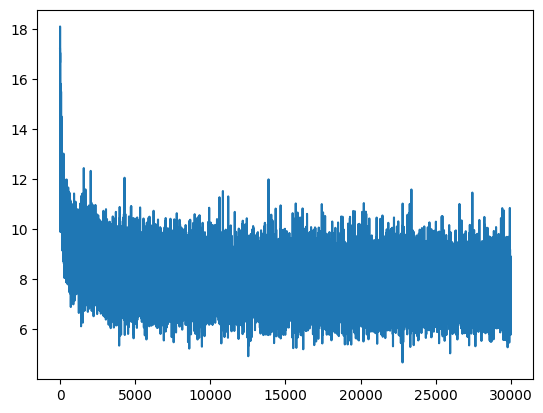

In [ ]:
plt.plot(list(range(EPOCHES)), loss_arr_unet)

## Plot Results

In [1]:
import matplotlib.pyplot as plt
STEPS = 1
#Define solver
solver = ODE_Solver(steps=STEPS)


fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

#====
#Data
x_samples = sample_8gaussians(DATA_N)
y_samples= sample_moons(DATA_N)

tr_samples = torch.tensor([[-4, 4], [-4, -4], [4, 4], [-5, 0]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

#Use solve method of SDE_Solver to get trajectory and mapped distribution
trajectory, y_pred = solver.solve_euler(x_samples, Unet)
trajectory_example, pred_example = solver.solve_euler(tr_samples, Unet)


axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3,
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1],
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1],
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)


ax.scatter(tr_samples[:, 0], tr_samples[:, 1],
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1],
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.5)

NameError: name 'ODE_Solver' is not defined

In [ ]:
from matplotlib.collections import LineCollection
def plot_trajectories(x_0, x_ts, n_samples, step=1):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x_0[:, 0], x_0[:, 1], s=1, c='green', label='Start')
    ax.scatter(x_ts[-1][:, 0], x_ts[-1][:, 1], s=1, c='orange', label='End')

    total_steps = (len(x_ts) - step - 1) // step
    lines = []

    with tqdm(total=n_samples, desc="Preparing trajectories") as pbar:
        for sample_i in range(n_samples):
            sample_lines = []
            for t in range(0, len(x_ts) - step - 1, step):
                sample_lines.append([
                    (x_ts[t][sample_i, 0].item(), x_ts[t][sample_i, 1].item()),
                    (x_ts[t + step][sample_i, 0].item(), x_ts[t + step][sample_i, 1].item())
                ])
            lines.extend(sample_lines)
            pbar.update(1)

    print("Plotting trajectories...")
    lc = LineCollection(lines, colors='green', alpha=0.1)
    ax.add_collection(lc)

    ax.legend()
    ax.set_title("Trajectories from 8 Gaussians to 2 Moons")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.show()

Plotting all trajectories

Preparing trajectories: 100%|██████████| 1000/1000 [00:02<00:00, 457.99it/s]


Plotting trajectories...


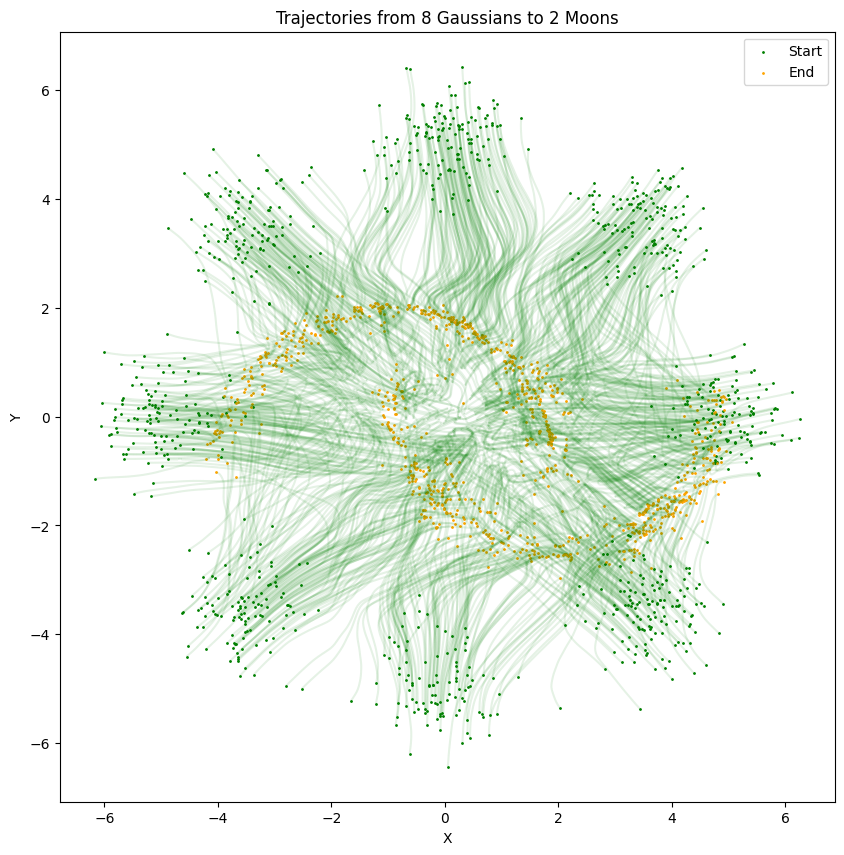

In [ ]:

n_samples = 1000
x_0 = sample_8gaussians(batch_size=n_samples)

trajectory_torched, prediction = solver.solve_euler(x_0, Unet)

# Convert to list of tensors for plotting
x_ts = [trajectory_torched[:, i, :] for i in range(trajectory_torched.shape[1])]

# Plot
plot_trajectories(x_0, x_ts, n_samples)

# Shortcut Model

In [3]:
### MODEL ####
import torch
import torch.nn as nn
import math

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        """
        Input: x shape can be [B] or [B, 1].
        Output: shape [B, size].
        """
        # 1) flatten out to [B] in case it has shape [B,1]
        if x.dim() > 1:
            x = x.squeeze(-1)

        x = x * self.scale
        half_size = self.size // 2
        emb = math.log(10000.0) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=x.device, dtype=x.dtype))
        # now emb = [half_size], x = [B]

        # 2) broadcast multiply => shape [B, half_size]
        temp = x.unsqueeze(-1) * emb.unsqueeze(0)  # => [B, half_size]

        # 3) sin & cos => shape [B, half_size] each
        sin_part = torch.sin(temp)
        cos_part = torch.cos(temp)
        emb = torch.cat((sin_part, cos_part), dim=-1)  # => [B, 2*half_size] = [B, self.size]

        # => shape [B, size].  No extra dimension.
        return emb

    def __len__(self):
        return self.size

class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.layer = SinusoidalEmbedding(size, scale=scale)

    def forward(self, x: torch.Tensor):
        return self.layer(x)

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()
    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class DiffModelWithD(nn.Module):
    """
    A small MLP that embeds (x, t, d):
      - x is 2D (the point in R^2)
      - t is a single scalar in [0,1]
      - d is an optional step-size scalar in [0,1/2,1/4,...]
    Then outputs velocity in R^2.
    """
    def __init__(self, d_in=2, hidden=128):
        super().__init__()
        self.hidden = hidden

        # We'll embed x just like before with scale=25 for each dimension
        # but we can also do something simpler. Let’s keep your original approach:
        self.x_proj_0 = PositionalEmbedding(hidden, scale=25.0)  # for x[:,0]
        self.x_proj_1 = PositionalEmbedding(hidden, scale=25.0)  # for x[:,1]

        # We'll also have embedding for t and d (each is 1D)
        self.t_proj = PositionalEmbedding(hidden)
        self.d_proj = PositionalEmbedding(hidden)

        # Then a simple stack of layers
        layers = [
            nn.Linear(hidden*4, hidden),  # we have x_proj_0 + x_proj_1 + t_proj + d_proj => 4*hidden total
            nn.GELU()
        ]
        for _ in range(4):
            layers.append(Block(hidden))
        layers.append(nn.Linear(hidden, d_in))  # output is 2D velocity
        self.layers = nn.Sequential(*layers)

    def forward(self, x, t, d=None):
        """
        x: (B, 2)
        t: (B, 1)
        d: (B, 1) or None; if None, treat as 0
        """
        if d is None:
            d = torch.zeros_like(t)

        x_emb_0 = self.x_proj_0(x[:,0:1])  # shape [B, hidden]
        x_emb_1 = self.x_proj_1(x[:,1:2])  # shape [B, hidden]
        t_emb   = self.t_proj(t.squeeze(-1))   # shape [B, hidden]
        d_emb   = self.d_proj(d.squeeze(-1))   # shape [B, hidden]

        # Concat
        concat_emb = torch.cat([x_emb_0, x_emb_1, t_emb, d_emb], dim=-1)
        return self.layers(concat_emb)



In [ ]:
def pick_discrete_steps(batch_size, device='cpu'):
    """
    Returns a tensor [batch_size] containing random picks from
    {1/2,1/4,1/8,1/16,1/32,1/64,1/128}, each equally likely.
    """
    powers_of_two = torch.tensor([2,4,8,16,32,64,128], device=device, dtype=torch.float)
    possible_steps = 1.0 / powers_of_two  # shape [7]
    random_inds = torch.randint(0, len(possible_steps), (batch_size,), device=device)
    selected_steps = possible_steps[random_inds]
    return selected_steps

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_flowmatching_shortcut(
    vnet, ema_net,
    epoches = 1000,
    batch_size = 64,
    lr = 1e-3,
    fraction_k = 0.25,   # e.g. 25% of each batch does standard FM (d=0)
    sig_min = 0.001
):
    """
    Shortcut training for 2D flow from 8 Gaussians -> 2 Moons.

    vnet(x, t, d) => predicts velocity in R^2.

    * fraction_k% of the batch => standard Flow Matching
         We want s(t, x_t, d=0) ~ x_1 - (1 - sig_min)* x_0
    * the remainder => 2-step self-consistency with random d in {1/2,1/4,...}.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vnet.to(device)
    ema_net.to(device)

    optimizer = torch.optim.AdamW(vnet.parameters(), lr=lr, weight_decay=0.1)
    loss_fn = nn.MSELoss()

    # We'll record each loss separately
    fm_losses = []
    cons_losses = []
    total_losses = []

    pbar = tqdm(range(epoches), desc="FlowMatch Shortcut Training", dynamic_ncols=True)
    for epoch in pbar:
        # 1) sample data & push to device
        t = torch.rand(size=(batch_size, 1), device=device)  # in [0,1]
        x_0 = sample_8gaussians(batch_size=batch_size).to(device)
        x_1 = sample_moons(batch_size=batch_size).to(device)

        # 2) define interpolation
        x_t = t * x_1 + (1. - t) * x_0

        # 3) pick discrete steps & do fraction K=some d=0
        d_vals = pick_discrete_steps(batch_size, device=device)
        K = int(batch_size * fraction_k)
        if K > 0:
            d_vals[:K] = 0.0

        # A) Standard FM for d=0
        fm_loss = 0.0
        if K > 0:
            idx_fm = torch.arange(K, device=device)
            pred_vel_fm = vnet(x_t[idx_fm], t[idx_fm], d_vals[idx_fm].unsqueeze(-1))
            target_vel_fm = x_1[idx_fm] - (1.0 - sig_min)* x_0[idx_fm]
            fm_loss = loss_fn(pred_vel_fm, target_vel_fm)

        # B) 2-step self-consistency for d>0
        consistency_loss = 0.0
        if K < batch_size:
            idx_cons = torch.arange(K, batch_size, device=device)
            t_cons = t[idx_cons]
            x_t_cons = x_t[idx_cons]
            d_cons = d_vals[idx_cons].unsqueeze(-1)  # shape [?, 1]

            # step 1
            s_t = vnet(x_t_cons, t_cons, d_cons)
            # step 2
            x_next = x_t_cons + s_t * d_cons
            # step 3
            t_next = torch.clamp(t_cons + d_cons, max=1.0)
            # step 4
            s_t_next = vnet(x_next, t_next, d_cons)
            # step 5
            s_target = 0.5*(s_t + s_t_next)
            # step 6
            s_2d = vnet(x_t_cons, t_cons, 2.0*d_cons)
            # step 7
            consistency_loss = loss_fn(s_2d, s_target)

        total_loss = fm_loss + consistency_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # EMA update
        ema(vnet, ema_model)

        # Record each loss in its list
        fm_losses.append(float(fm_loss))
        cons_losses.append(float(consistency_loss))
        total_losses.append(float(total_loss))

        pbar.set_postfix({
            "fm_loss": float(fm_loss),
            "cons_loss": float(consistency_loss),
            "total_loss": float(total_loss)
        })

    # Return 3 arrays so we can plot them individually
    return fm_losses, cons_losses, total_losses


In [ ]:
# 4A) Instantiate the network and train:
import copy

def ema(source, target, decay=0.999):
    """EMA update of target's params from source."""
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for k in source_dict.keys():
        target_dict[k].data.copy_(
            target_dict[k].data * decay + source_dict[k].data * (1 - decay)
        )

vnet_shortcut = DiffModelWithD(d_in=2, hidden=768)

ema_model = copy.deepcopy(vnet_shortcut)

# Print model size
model_size = sum(p.numel() for p in ema_model.parameters())
print("Model params: %.2f M" % (model_size / 1024 / 1024))

fm_ls, cons_ls, tot_ls = train_flowmatching_shortcut(
    vnet_shortcut, ema_net=ema_model,
    epoches=50000,
    batch_size=128,
    lr=1e-3,
    fraction_k=0.75  # or 0.3, 0.5, etc.
)



Model params: 4.51 M


FlowMatch Shortcut Training: 100%|██████████| 200001/200001 [50:49<00:00, 65.59it/s, fm_loss=7.18, cons_loss=0.00981, total_loss=7.19]


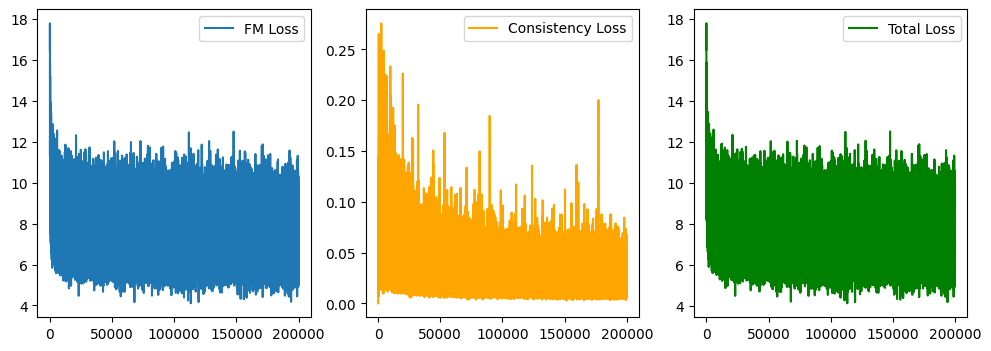

In [ ]:
# Then to plot each:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(fm_ls, label="FM Loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(cons_ls, label="Consistency Loss", color="orange")
plt.legend()
plt.subplot(1,3,3)
plt.plot(tot_ls, label="Total Loss", color="green")
plt.legend()
plt.show()

In [4]:
########################################
# 1) ODE Solver definition (same as your code):
########################################
class ODE_Solver_SC(nn.Module):
    def __init__(self, steps=100, start_t=0.0, end_t=1.0):
        super().__init__()
        self.start_t = start_t
        self.end_t   = end_t
        self.steps   = steps
        self.delta_t = (end_t - start_t) / steps

    @torch.no_grad()
    def solve_euler(self, x, vnet, printable=True):
        """
        x:  [B, 2] (on the same device as vnet)
        vnet: a network with signature vnet(x, t, d)
        """
        batch_size = x.shape[0]
        t_ = torch.zeros((batch_size, 1), device=x.device) + self.start_t
        dt_ = self.delta_t

        trajectory = [x]
        for step in range(self.steps):
            # pass d=dt_ to the net
            vel = vnet(x, t_, torch.full_like(t_, dt_))
            x   = x + vel * dt_
            t_  = t_ + dt_
            t_  = torch.clamp(t_, max=self.end_t)
            trajectory.append(x)

        out_trajectory = torch.stack(trajectory, dim=1)  # shape [B, steps+1, 2]
        out_final = out_trajectory[:,-1,:]              # shape [B,2]
        if printable:
            return out_trajectory.cpu(), out_final.cpu()
        else:
            return out_trajectory, out_final


########################################
# 2) Example usage & plotting
########################################

# Suppose you’ve already trained vnet_shortcut
# (from your train_flowmatching_shortcut(...) function).

# We define:
STEPS = 4
DATA_N = 2000

# Make sure your vnet_shortcut is on the same device used in ODE_Solver
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vnet_shortcut.to(device)

# 2A) Instantiate solver:
solver = ODE_Solver_SC(steps=STEPS)

# 2B) Sample data
x_samples = sample_8gaussians(DATA_N).to(device)  # shape [1000,2]
y_samples = sample_moons(DATA_N).to(device)        # shape [1000,2]

# 2C) Some “tracer” samples for trajectory lines
tr_samples = torch.tensor([[-4, 4], [-4, -4], [4, 4], [-5, 0]],
                          dtype=torch.float, device=device)
# We'll replicate them 3 times => 12 total
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)

# 2D) Solve / map each set
trajectory, y_pred = solver.solve_euler(x_samples, ema_model)     # shape: [B, steps+1, 2], [B, 2]
trajectory_ex, y_pred_ex = solver.solve_euler(tr_samples, ema_model)


# 3) Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

# Left panel => input & target
axes[0].scatter(x_samples[:, 0].cpu(), x_samples[:, 1].cpu(),
                alpha=0.3, c="g", s=32, edgecolors="black",
                label=r"Input distribution $p_0$")
axes[0].scatter(y_samples[:, 0].cpu(), y_samples[:, 1].cpu(),
                c="orange", s=32, edgecolors="black",
                label=r"Target distribution $p_1$")
axes[0].legend(loc="lower left")
axes[0].set_title("Source + Target Data")
axes[0].grid(zorder=-20)
axes[0].set_xlim([-8, 8])
axes[0].set_ylim([-8, 8])

# Right panel => the mapped distribution & some trajectories
axes[1].scatter(y_pred[:, 0], y_pred[:, 1],
                c="yellow", s=32, edgecolors="black",
                alpha=0.6, label="Fitted distribution", zorder=1)

# Start points for tracers
axes[1].scatter(tr_samples[:, 0].cpu(), tr_samples[:, 1].cpu(),
                c="green", s=128, edgecolors="black",
                label="Trajectory start ($x \\sim p_0$)", zorder=3)

# End points
axes[1].scatter(y_pred_ex[:, 0], y_pred_ex[:, 1],
                c="red", s=64, edgecolors="black",
                label="Trajectory end (fitted)", zorder=3)

# Draw lines for each trajectory
for i in range(tr_samples.size(0)):
    # shape [steps+1, 2]
    points = trajectory_ex[i]  # shape [steps+1, 2], on CPU
    # Plot
    axes[1].plot(points[:, 0], points[:, 1],
                 color="grey", linewidth=1.5, zorder=2)
    if i == 0:
        axes[1].plot(points[:, 0], points[:, 1],
                     color="grey", linewidth=1.5, zorder=2,
                     label=r"Trajectory of $T_{\theta}$")

axes[1].grid(zorder=-20)
axes[1].set_xlim([-8, 8])
axes[1].set_ylim([-8, 8])
axes[1].legend(loc="lower left")
axes[1].set_title("Mapped Distribution + Trajectories")

fig.tight_layout(pad=0.5)
plt.show()
plt.show()

NameError: name 'vnet_shortcut' is not defined